## Linear Regression Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import os
import sys
try:
    # Append PySpark to PYTHONPATH / Spark 2.1.0
    sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python"))
    sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python", "lib",
                                 "py4j-0.10.4-src.zip"))
except KeyError as e:
    print("SPARK_HOME is not set", e)
    sys.exit(1)
    
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.linalg import Vectors

In [2]:
spark_session = SparkSession.builder.getOrCreate()

### Generate Data

In [3]:
# y = b_o + b_1*x + error
# b_0 = 0.5, b_1 = 0.3, error = normally distributed
x = np.arange(100)
error = np.random.normal(0, size=(100,))
y = 0.5 + 0.3 * x + error

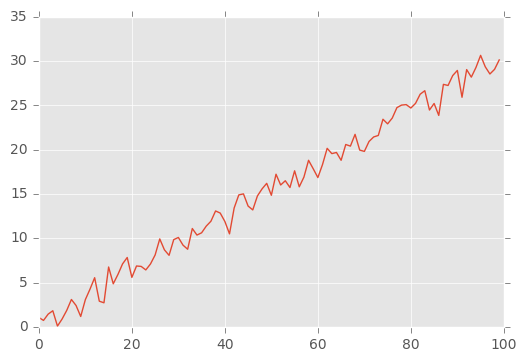

In [4]:
plt.plot(x, y)
pass

### Convert to Spark DataFrame

In [5]:
data = pd.DataFrame([(i, j) for i, j in zip(x,y)], columns = ["x", "y"])

In [6]:
data_spark = spark_session.createDataFrame(data)

In [7]:
data_spark.show()

+---+-------------------+
|  x|                  y|
+---+-------------------+
|  0| 1.0587275386834776|
|  1|  0.730768657923699|
|  2|  1.441505299673081|
|  3| 1.8233212076934802|
|  4|0.08898950675695438|
|  5| 0.8905242974616074|
|  6| 1.8679060524757731|
|  7|  3.095184223812484|
|  8|  2.414412495174162|
|  9| 1.1768633094453045|
| 10| 3.0792184885280003|
| 11| 4.2629489155699245|
| 12|  5.553211662296347|
| 13| 2.8988604343106927|
| 14| 2.7209885599958863|
| 15| 6.7608452493958175|
| 16| 4.8662954638016185|
| 17| 5.9140470253067665|
| 18|  7.112236630438867|
| 19|  7.833714317052323|
+---+-------------------+
only showing top 20 rows



In [8]:
df = spark_session.createDataFrame((data_spark
 .rdd
 .map(lambda row: (row[1], 0.5, Vectors.dense(row[0]))) 
), ["label", "weight", "features"] )

### Simple Linear Regression

In [9]:
lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", weightCol="weight")

In [10]:
model = lr.fit(df)

In [11]:
model.coefficients

DenseVector([0.302])

In [12]:
model.intercept

0.3750432334219888

In [13]:
model.transform(df).show()

+-------------------+------+--------+------------------+
|              label|weight|features|        prediction|
+-------------------+------+--------+------------------+
| 1.0587275386834776|   0.5|   [0.0]|0.3750432334219888|
|  0.730768657923699|   0.5|   [1.0]|0.6770651715916667|
|  1.441505299673081|   0.5|   [2.0]|0.9790871097613447|
| 1.8233212076934802|   0.5|   [3.0]|1.2811090479310225|
|0.08898950675695438|   0.5|   [4.0]|1.5831309861007006|
| 0.8905242974616074|   0.5|   [5.0]|1.8851529242703784|
| 1.8679060524757731|   0.5|   [6.0]|2.1871748624400564|
|  3.095184223812484|   0.5|   [7.0]|2.4891968006097343|
|  2.414412495174162|   0.5|   [8.0]| 2.791218738779412|
| 1.1768633094453045|   0.5|   [9.0]|  3.09324067694909|
| 3.0792184885280003|   0.5|  [10.0]|3.3952626151187677|
| 4.2629489155699245|   0.5|  [11.0]| 3.697284553288446|
|  5.553211662296347|   0.5|  [12.0]| 3.999306491458124|
| 2.8988604343106927|   0.5|  [13.0]| 4.301328429627802|
| 2.7209885599958863|   0.5|  [

In [15]:
# save model
model.write().overwrite().save("model")

### Predict New Data

In [16]:
model_load = LinearRegressionModel.load("model")

In [17]:
# need the index as dummy column
predict_df = spark_session.createDataFrame([(1, Vectors.dense(0))], ["index", "features"])

In [18]:
model_load.transform(predict_df).show()

+-----+--------+------------------+
|index|features|        prediction|
+-----+--------+------------------+
|    1|   [0.0]|0.3750432334219888|
+-----+--------+------------------+



In [33]:
str(model_load.transform(predict_df).collect()[0])

'Row(index=1, features=DenseVector([0.0]), prediction=0.3750432334219888)'

In [21]:
spark_session.sparkContext.parallelize(range(10)).collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]